# RFM analysis

#### For this task uses the public dataset: https://www.kaggle.com/olistbr/brazilian-ecommerce in particular the files olist_orders_dataset.csv and olist_order_payments_dataset.csv. 

### The Purpose and Impact of RFM Analysis:

The primary goal of RFM analysis is to segment customers based on their behavior and tailor marketing strategies accordingly. By understanding customer segments through RFM analysis, businesses can:

Improve Customer Retention: By targeting specific segments with personalized offers and incentives, businesses can improve customer retention rates and reduce churn.

Increase Revenue: Targeted marketing strategies based on RFM analysis can lead to increased sales and revenue as customers are more likely to respond to personalized offers.

Enhance Customer Loyalty: By recognizing and rewarding loyal customers appropriately, businesses can strengthen customer loyalty and foster long-term relationships.

Using RFM analysis effectively enables businesses to engage with customers in a targeted and strategic manner, leading to improved customer relationships and sustainable business growth.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [40]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')

It makes sense to take (order_delivered_carrier_date) as the final purchase date, so let's convert it to 'datetime64'. Create an index 'order_id' for both datasets and connect it by index 'order_id'.

In [41]:
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])

df_payments = df_payments.set_index('order_id')
df_orders = df_orders.set_index('order_id')

order_payment = pd.merge(df_orders, df_payments, left_index=True, right_index=True)

In [42]:
last_date = order_payment['order_delivered_carrier_date'].max() + timedelta(days=1)
rfmTable = order_payment.reset_index().groupby('customer_id').agg({'order_delivered_carrier_date': lambda x: (last_date - x.max()).days,
                                                 'order_id': lambda x: len(x), 
                                                 'payment_value': lambda x: x.sum()})
rfmTable.rename(columns={'order_delivered_carrier_date': 'recency', 
                          'order_id': 'frequency', 
                          'payment_value': 'monetary_value'}, inplace=True)

In [43]:
rfmTable.head(5)

,recency,frequency,monetary_value
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,299.0,1,114.74
000161a058600d5901f007fab4c27140,420.0,1,67.41
0001fd6190edaaf884bcaf3d49edf079,560.0,1,195.42
0002414f95344307404f0ace7a26f1d5,389.0,1,179.35
000379cdec625522490c315e70c7a9fb,161.0,1,107.01


Give score to customers

In [36]:
quantiles = rfmTable.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

def RScore(x,p,d):
     if x <= d[p][0.20]:
        return 1
     elif x <= d[p][0.40]:
        return 2
     elif x <= d[p][0.60]: 
        return 3
     elif x<=d[p][0.80]:
        return 4
     else:
        return 5

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(RScore, args=('monetary_value',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)

print(segmented_rfm.head())

C:\Users\kirdy\AppData\Local\Temp\ipykernel_22492\455184214.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = rfmTable.quantile(q=[0.20, 0.40, 0.60, 0.80])


                                  recency  frequency  monetary_value  \
customer_id                                                            
00012a2ce6f8dcda20d059ce98491703    299.0          1          114.74   
000161a058600d5901f007fab4c27140    420.0          1           67.41   
0001fd6190edaaf884bcaf3d49edf079    560.0          1          195.42   
0002414f95344307404f0ace7a26f1d5    389.0          1          179.35   
000379cdec625522490c315e70c7a9fb    161.0          1          107.01   

                                  r_quartile  f_quartile  m_quartile RFMScore  
customer_id                                                                    
00012a2ce6f8dcda20d059ce98491703           4           1           3      413  
000161a058600d5901f007fab4c27140           5           1           2      512  
0001fd6190edaaf884bcaf3d49edf079           5           1           4      514  
0002414f95344307404f0ace7a26f1d5           4           1           4      414  
000379cdec62552

In [47]:
def segment_user(row):
    if row['r_quartile'] == 5 and row['f_quartile'] == 5 and row['m_quartile'] == 5:
        return 'Active and Loyal'
    elif row['r_quartile'] == 1 and row['f_quartile'] == 1 and row['m_quartile'] == 1:
        return 'Lost Customers'
    elif row['r_quartile'] in [1, 2] and row['f_quartile'] in [4, 5] and row['m_quartile'] in [4, 5]:
        return 'At Risk of Churn'
    elif row['r_quartile'] in [4, 5] and row['f_quartile'] == 1 and row['m_quartile'] in [1, 2, 3, 4, 5]:
        return 'Recent Buyers'
    else:
        return 'Other'

segmented_rfm['Segment'] = segmented_rfm.apply(segment_user, axis=1)

print(segmented_rfm)


                                  recency  frequency  monetary_value  \
customer_id                                                            
00012a2ce6f8dcda20d059ce98491703    299.0          1          114.74   
000161a058600d5901f007fab4c27140    420.0          1           67.41   
0001fd6190edaaf884bcaf3d49edf079    560.0          1          195.42   
0002414f95344307404f0ace7a26f1d5    389.0          1          179.35   
000379cdec625522490c315e70c7a9fb    161.0          1          107.01   
...                                   ...        ...             ...   
fffecc9f79fd8c764f843e9951b11341    165.0          3           81.36   
fffeda5b6d849fbd39689bb92087f431    110.0          1           63.13   
ffff42319e9b2d713724ae527742af25     89.0          1          214.13   
ffffa3172527f765de70084a7e53aae8    368.0          1           45.50   
ffffe8b65bbe3087b653a978c870db99      NaN          1           18.37   

                                  r_quartile  f_quartile  m_qua

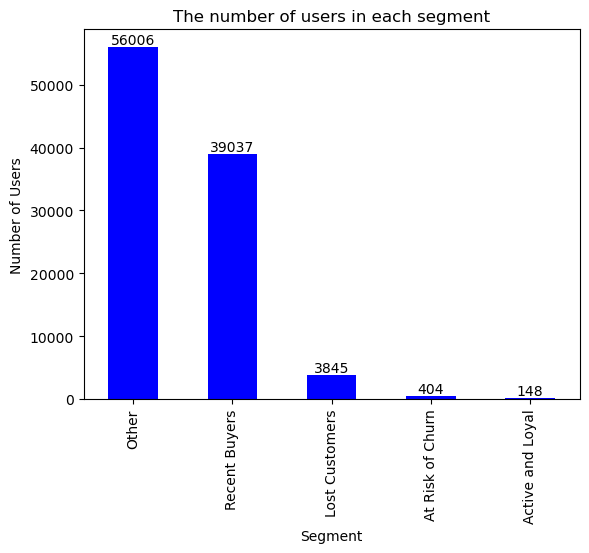

In [52]:
segment_counts = segmented_rfm['Segment'].value_counts()
ax = segment_counts.plot(kind='bar', color='blue')
plt.title('The number of users in each segment')
plt.xlabel('Segment')
plt.ylabel('Number of Users')

# Добавление аннотаций к каждому столбцу
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

plt.show()

### RFM Analysis Interpretation by Segment:

#### R=5, F=5, M=5: These customers have paid frequently, a lot, and recently. They are the most loyal and active users. Targeted actions could involve exclusive offers, personalized rewards, or early access to new products to maintain their loyalty.

#### R=1, F=1, M=1: Customers in this segment pay little, rarely, and it has been a long time since their last purchase. They are most likely lost clients. It might not be cost-effective to try to re-engage them if the cost of reacquisition exceeds the expected profit.

#### R=1/2, F=4/5, M=4/5: These are loyal users who are on the verge of leaving. Offering them bonuses, discounts, or personalized incentives could help in winning them back and retaining their loyalty.

#### R=4/5, F=1, M=1/2/3/4/5: Customers in this segment have recently made a purchase. Encouraging them to buy more through targeted promotions, cross-selling, or upselling strategies could help increase their engagement and lifetime value.